<a href="https://colab.research.google.com/github/FelipeSotoG/U-Net-ResNetBlocks/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descarga datos
Los datos se encuentran en el drive, por lo que usara gdown para sacarlos directamente y no tener que hacer la coneccion, ya que estamos descargando un zip.

In [1]:
!gdown https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt

Downloading...
From: https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt
To: /content/input.zip
100% 597M/597M [00:04<00:00, 120MB/s]


In [2]:
!unzip -q input.zip

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [4]:
import nibabel as nib
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import cv2

In [5]:
import imageio as iio
import glob
from skimage.transform import resize
src="/content/input/train"
imag="/images/"
X=np.zeros((len(glob.glob(src+imag+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+imag+"*.png"))):
  X[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)
mas="/masks/"
Y=np.zeros((len(glob.glob(src+mas+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+mas+"*.png"))):
  Y[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)/255

##Borrar directorio /input en caso de error

In [ ]:
!rm -r /content/input

##Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=2)

##Resnet

In [7]:
def DiceMetric(y_true, y_pred):
  smooth=1e-6 
  gama=2
  y_true, y_pred = tf.cast(
      y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
  nominator = 2 * \
      tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
  denominator = tf.reduce_sum(
      y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
  result = tf.divide(nominator, denominator)
  return result
def DiceLoss(y_true, y_pred):
      result= 1- DiceMetric(y_true, y_pred)
      return result

In [8]:
def conv_e_block(X,f,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(X)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[2], (1, 1), kernel_initializer='he_normal', padding='same')(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  s = tf.keras.layers.Conv2D(f[2], (1, 1), kernel_initializer='he_normal', padding='same')(X)
  s = tf.keras.layers.BatchNormalization(axis=3)(s)
  c = tf.keras.layers.ReLU()(c)
  return (c,s)

In [9]:
def conv_block(X,f,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(X)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[2], (1, 1), kernel_initializer='he_normal', padding='same')(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  s = tf.keras.layers.Conv2D(f[2], (1, 1), kernel_initializer='he_normal', padding='same')(X)
  s = tf.keras.layers.BatchNormalization(axis=3)(s)
  c = tf.keras.layers.Add()([s,c])
  c = tf.keras.layers.ReLU()(c)
  return c

In [10]:
def conv_u_block(X,f,I,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(X)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[2], (1, 1), kernel_initializer='he_normal', padding='same')(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Add()([I,c])
  c = tf.keras.layers.ReLU()(c)
  return c

In [12]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1,z1 = conv_e_block(s,[8,8,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2,z2 = conv_e_block(c1,[16,16,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3,z3 = conv_e_block(c2,[32,32,64],0.2)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4,z4 = conv_e_block(c3,[64,64,128],0.2)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = conv_block(p4,[128,128,256],0.3)


#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
c6 = conv_u_block(u6,[64,64,128],z4,0.2)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(1, 1), padding='same')(c6)
c7 = conv_u_block(u7,[32,32,64],z3,0.2)


u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(1, 1), padding='same')(c7)
c8 = conv_u_block(u8,[16,16,32],z2)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(1, 1), padding='same')(c8)
c9 = conv_u_block(u9,[8,8,16],z1)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 128, 128, 8)  16          ['lambda_1[0][0]']               
                                                                                                  
 batch_normalization_32 (BatchN  (None, 128, 128, 8)  32         ['conv2d_33[0][0]']        

##Model Fit

In [13]:
model.fit(X_train,Y_train,batch_size=16,epochs=25,validation_split=0.2)

Epoch 1/25
124/124 [==============================] - 42s 199ms/step - loss: 0.1867 - accuracy: 0.9482 - DiceMetric: 0.1254 - val_loss: 0.1328 - val_accuracy: 0.9854 - val_DiceMetric: 0.1695
Epoch 2/25
124/124 [==============================] - 22s 179ms/step - loss: 0.0577 - accuracy: 0.9870 - DiceMetric: 0.2270 - val_loss: 0.0659 - val_accuracy: 0.9855 - val_DiceMetric: 0.2629
Epoch 3/25
124/124 [==============================] - 22s 179ms/step - loss: 0.0365 - accuracy: 0.9871 - DiceMetric: 0.4277 - val_loss: 0.0342 - val_accuracy: 0.9852 - val_DiceMetric: 0.5061
Epoch 4/25
124/124 [==============================] - 22s 179ms/step - loss: 0.0271 - accuracy: 0.9873 - DiceMetric: 0.5306 - val_loss: 0.0309 - val_accuracy: 0.9839 - val_DiceMetric: 0.5500
Epoch 5/25
124/124 [==============================] - 22s 179ms/step - loss: 0.0227 - accuracy: 0.9874 - DiceMetric: 0.5844 - val_loss: 0.0233 - val_accuracy: 0.9866 - val_DiceMetric: 0.6061
Epoch 6/25
124/124 [=========================

In [ ]:
scores= model.evaluate(X_test, Y_test, verbose=0)
print(f'Score for fold {0}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Score for fold 0: loss of 0.013260588981211185; accuracy of 98.9195168018341%


##Testing

In [ ]:
Ypred=model.predict(X_test)

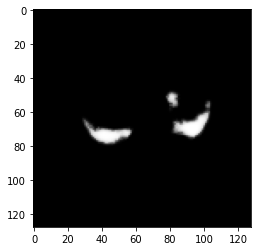

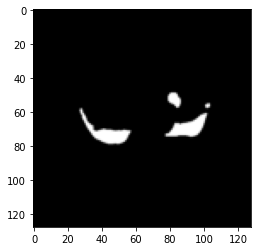

In [ ]:
plt.imshow(np.reshape(Ypred[160],(128,128)), cmap=plt.cm.gray)
plt.show()
plt.imshow(np.reshape(Y_test[160],(128,128)), cmap=plt.cm.gray)
plt.show()

In [ ]:
def dice(true_mask, pred_mask, non_seg_score=1.0):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.  
        
        Returns:
            A scalar representing the Dice coefficient between the two segmentations. 
        
    """
    assert true_mask.shape == pred_mask.shape

    true_mask = np.asarray(true_mask).astype(bool)
    pred_mask = np.asarray(pred_mask).astype(bool)

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [ ]:
diceaux=dice(Y_test[160],Ypred[160])
diceaux

0.07394345500499618

## Model Fit Kfold

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [15]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

25 epochs

In [16]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.014021586626768112; accuracy of 98.92089366912842% DiceMetric of 83.75591039657593%
Score for fold 2: loss of 0.019117744639515877; accuracy of 98.81448745727539% DiceMetric of 84.43223834037781%
Score for fold 3: loss of 0.01881265453994274; accuracy of 98.86800646781921% DiceMetric of 81.77867531776428%
Score for fold 4: loss of 0.016339754685759544; accuracy of 98.87001514434814% DiceMetric of 83.96406173706055%
Score for fold 5: loss of 0.01778031513094902; accuracy of 98.91332983970642% DiceMetric of 83.52100849151611%


50 epochs

In [17]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=50,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.020024169236421585; accuracy of 98.9259123802185% DiceMetric of 83.23488235473633%
Score for fold 2: loss of 0.027436159551143646; accuracy of 98.80136251449585% DiceMetric of 78.62027883529663%
Score for fold 3: loss of 0.027285216376185417; accuracy of 98.84647130966187% DiceMetric of 76.36862397193909%
Score for fold 4: loss of 0.02436514012515545; accuracy of 98.84511828422546% DiceMetric of 74.79293942451477%
Score for fold 5: loss of 0.02152051404118538; accuracy of 98.88449311256409% DiceMetric of 80.96136450767517%
